<a href="https://colab.research.google.com/github/blawok/CryptocurrencyArbitrage/blob/master/toxic_comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toxic comment classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

from itertools import combinations
from wordcloud import WordCloud ,STOPWORDS

Load datasets

In [0]:
train = pd.read_csv('drive/My Drive/Toxic_Comments/data/train.csv')
test = pd.read_csv('drive/My Drive/Toxic_Comments/data/test.csv')
test_labels = pd.read_csv('drive/My Drive/Toxic_Comments/data/test_labels.csv')
test_set = pd.concat([test.reset_index(drop=True), test_labels.iloc[:,1:]], axis=1)
test_set = test_set[test_set.toxic != -1]

# EDA

## How does the data look like?

In [30]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [0]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Let's see how the distributions vary by each category:





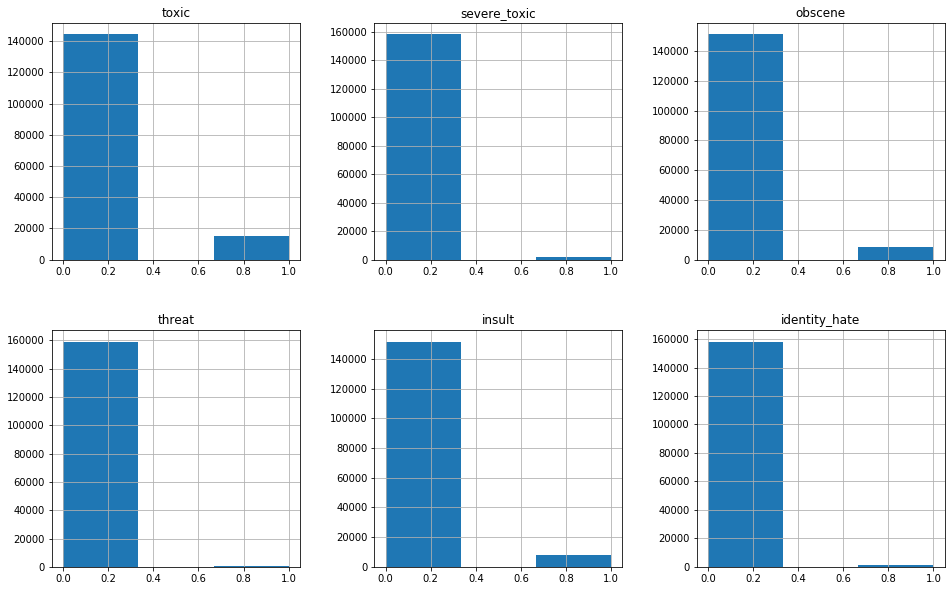

In [0]:
fig, axes = plt.subplots(2,3, figsize=(16, 10))
i = 2
for triaxis in axes:
    for axis in triaxis:
        train.hist(column = train.columns[i], bins = 3, ax=axis)
        i = i+1
plt.show()

Toxic, obscene and insult categories have the most positive (=1) observations. Let see if this is also the issue for test set.

In [0]:
test_set.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,153164.000000,153164.000000,153164.000000,153164.000000,153164.000000,153164.000000
mean,-0.542530,-0.579895,-0.558193,-0.580913,-0.559916,-0.577642
std,0.572465,0.498408,0.542966,0.496195,0.539594,0.503260
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


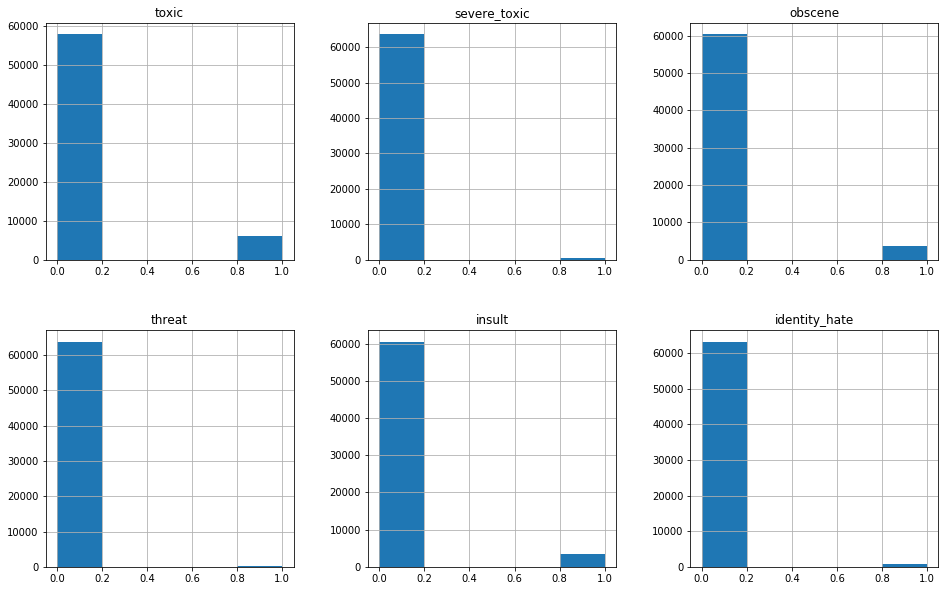

In [0]:
fig, axes = plt.subplots(2,3, figsize=(16, 10))
i = 2
for triaxis in axes:
    for axis in triaxis:
        test_set.hist(column = test_set.columns[i], bins = 5, ax=axis)
        i = i+1
plt.show()

Fortunately, the distribution looks very similar to the training set, so there would not be any problems with imbalanced data between train and test.


Are there any rows with missing data?

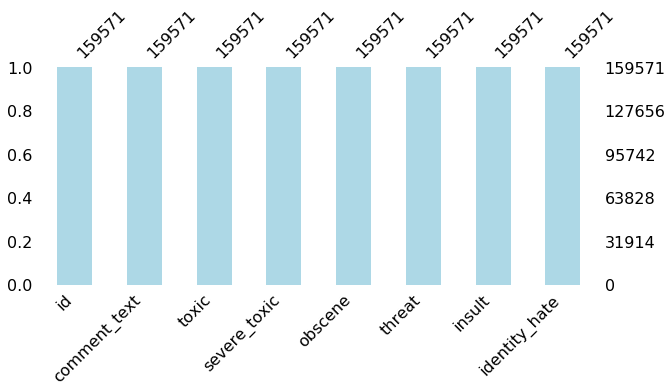

In [0]:
msno.bar(train, color='lightblue', figsize=(10,4))

All columns have data in 100% of observations.

Let's explore comment_text column which consists of Wikipedia posts.

In [0]:
lens = train.comment_text.str.len()
print(f'Mean of the comments length: {lens.mean()}')
print(f'Standard deviation of the comments length: {lens.std()}')
print(f'Max of the comments length: {lens.max()}')
print(f'Min of the comments length: {lens.min()}')

Mean of the comments length: 394.0732213246768
Standard deviation of the comments length: 590.7202819048923
Max of the comments length: 5000
Min of the comments length: 6


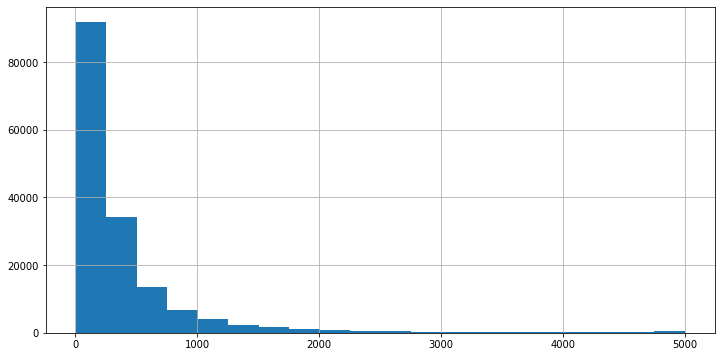

In [0]:
lens.hist(figsize = (12,6), bins = 20)

We clearly see that the distribution of lengths is right skewed, so we are dealing mostly with short comments.

Let's see if the categories are correlated.

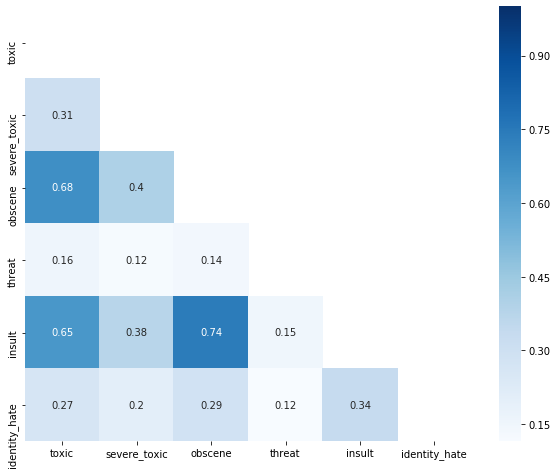

In [0]:
label_cols = train.iloc[:,2:].columns
train['other'] = 1-train[label_cols].max(axis=1)
temp_df=train.iloc[:,2:-1]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True,
            cmap="Blues",
            mask=mask)

We can see that **insult** is highly correlated with **obscene** and **toxic**, as well as **obscene** is higly correlated with **toxic**.

# Text Mining Analysis

### Wordclouds

In [0]:
stopword=set(STOPWORDS)
stopword.add('NIGGER')
stopword.add('JEW')

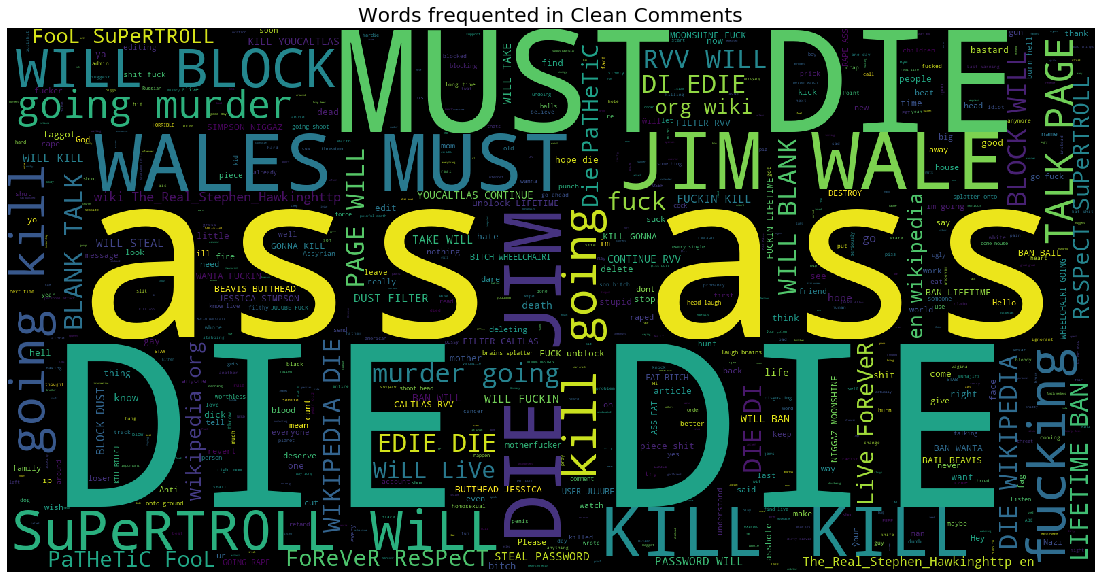

In [0]:
subset=train[train.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",
              max_words=2000,
              stopwords=stopword,
              width=1600, height=800)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.tight_layout(pad=0)
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc)
plt.show()

### Length to category correlation

### Topic modelling per category

### Unique words / unique comments

### Senitment?

# Preprocessing

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
nltk.download('stopwords')
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Remove stopwords

In [4]:
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
train['clean_comments'] = train['comment_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
test_set['clean_comments'] = test_set['comment_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

### Tokenize data

In [0]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = train[list_classes].values
y_test = test_set[list_classes].values
list_sentences_train = train["clean_comments"]
list_sentences_test = test_set["clean_comments"]

In [47]:
max_features = 30000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))

word_index = tokenizer.word_index
vocab_size=len(word_index)
print(f"Our vocabulary size: {vocab_size}")

list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

Our vocabulary size: 209630


Save the tokenizer pickle

In [0]:
with open('drive/My Drive/Toxic_Comments/objects/tokenizer_30000.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('drive/My Drive/Toxic_Comments/objects/tokenizer_30000.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

Pad sentences to ensure that all input has the same length

In [0]:
max_length = 250
padding_type='post'
X_train = pad_sequences(list_tokenized_train, maxlen=max_length, padding=padding_type)
X_test = pad_sequences(list_tokenized_test, maxlen=max_length, padding=padding_type)

# Classifier

In [0]:
from tensorflow.keras.layers import Dense, Flatten, LSTM, GRU, Embedding, Dropout, Activation, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import model_from_json
from sklearn.metrics import roc_auc_score

def save_model(model,name):
    json_string = model.to_json()
    open('drive/My Drive/Toxic_Comments/model_files/'+name+'_architecture.json', 'w').write(json_string)
    model.save_weights('drive/My Drive/Toxic_Comments/model_files/'+name+'_weights.h5')
    
def load_model(name):
    model = model_from_json(open('drive/My Drive/Toxic_Comments/model_files/'+name+'_architecture.json').read())
    model.load_weights('drive/My Drive/Toxic_Comments/model_files/'+name +'_weights.h5')
    return(model)

Download GloVe embeddings

In [0]:
embedding_dim = 100

In [54]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-01-24 10:40:13--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 2607:f8b0:4001:c12::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   178MB/s    in 1.9s    

2020-01-24 10:40:15 (178 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



## Create model object with network architecture

We experimeted with many architectures, however the one below gave us the best results. It is worth mentioning that simple CNN had the best results on training set, but did poorly on the test set.

Our architecture consists of: 

*   GloVe embeddings (not trainable) followed by dropout
*   1-dimensional convolution with maxpooling as an embedding encoder
*   Bidirectional Gated Recurrent Unit with 128 units followed by dropout and maxpooling
*   Dense layer
*   Output layer with sigmoid activation

Whole network consists of 457,606 trainable parameters.

Network will be optimized by Adam optimizer on default settings.

As it is multi-label classification problem we used binary crossentropy loss.

In [0]:
model = Sequential([
                    
    Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    Dropout(0.1),

    Conv1D(256, 5),
    MaxPooling1D(pool_size=4),

    Bidirectional(GRU(128, dropout=0.1, recurrent_dropout=0.1, return_sequences=True)),
    Dropout(0.1),
    GlobalMaxPooling1D(),

    Dense(128, activation='relu'),
    Dropout(0.1),

    Dense(6, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Below we can see the architecture in details

In [120]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 250, 100)          20963100  
_________________________________________________________________
dropout_63 (Dropout)         (None, 250, 100)          0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 246, 256)          128256    
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 61, 256)           0         
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 61, 256)           295680    
_________________________________________________________________
dropout_64 (Dropout)         (None, 61, 256)           0         
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 256)             

In [121]:
num_epochs = 10
batch_size = 512
history = model.fit(X_train,
                    y_train,
                    epochs=num_epochs,
                    batch_size = batch_size,
                    verbose=1,
                    shuffle=True)

Train on 159571 samples
Epoch 1/10
159571/159571 [==============================] - 63s 393us/sample - loss: 0.0837 - acc: 0.9733
Epoch 2/10
159571/159571 [==============================] - 59s 372us/sample - loss: 0.0573 - acc: 0.9795
Epoch 3/10
159571/159571 [==============================] - 61s 381us/sample - loss: 0.0523 - acc: 0.9807
Epoch 4/10
159571/159571 [==============================] - 60s 378us/sample - loss: 0.0486 - acc: 0.9819
Epoch 5/10
159571/159571 [==============================] - 61s 379us/sample - loss: 0.0455 - acc: 0.9828
Epoch 6/10
159571/159571 [==============================] - 62s 385us/sample - loss: 0.0435 - acc: 0.9834
Epoch 7/10
159571/159571 [==============================] - 61s 380us/sample - loss: 0.0409 - acc: 0.9844
Epoch 8/10
159571/159571 [==============================] - 61s 380us/sample - loss: 0.0390 - acc: 0.9850
Epoch 9/10
159571/159571 [==============================] - 61s 380us/sample - loss: 0.0370 - acc: 0.9856
Epoch 10/10
159571/159

In [122]:
score = model.evaluate(X_test, 
                       y_test,
                       batch_size = 512,
                       verbose = 1)

63978/63978 [==============================] - 7s 108us/sample - loss: 0.0827 - acc: 0.9678


We achieved great accuracy on training set 98.61%, accuracy on the test set is not much worse: 96.78%

In the Kaggle challenge ROC AUC score is used so we can also compute that.

In [0]:
y_eval = model.predict(X_test)

In [140]:
print(f"Achieved ROC AUC score: {round(roc_auc_score(y_test, y_eval),5)*100}%")

Achieved ROC AUC score: 96.953%


In [0]:
save_model(model, "cnn_gru_glove_9678")

# Exploring own embeddings


In the beginning we trained our own embeddings, the accuracy was better on GloVe embeddings so we used them. However, in the attachments we included files with our embeddings that allow you to visualize them using Tensorflow Projector.

To use it you will need to go to https://projector.tensorflow.org/ and load files from attachments. (vecs.tsv and meta.tsv)

After you upload the files you should see something like this:

![alt text](https://drive.google.com/uc?id=1s8Uak7l8KavLWdfqNoVwntNQNFofwlyv)


In [0]:
word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [113]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(20000, 128)


In [0]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')